In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns
import re
from tqdm.notebook import tqdm, trange
from tqdm import tqdm
from matplotlib_venn import venn3
from scipy import stats

import collections
import plotly.express as px
import plotly.io as pio

import clipboard

from pymongo import InsertOne, DeleteMany, ReplaceOne, UpdateOne


%load_ext autoreload
%autoreload 1
# %aimport product_cleaner
### %aimport food_api
# %aimport Edamam_API
# %aimport FNDDS_base
%aimport query_builder
%aimport grocery_base

In [2]:
font_size =12

SMALL_SIZE = font_size
MEDIUM_SIZE = font_size
BIGGER_SIZE = font_size

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

matplotlib.rcParams['font.serif'] = "Times New Roman"
matplotlib.rcParams['font.family'] = "serif"
sns.set_style({'font.family': 'serif', 'font.serif': 'Times New Roman'})
# sns.set_style("white")
# sns.set_style("ticks")
sns.set(style="ticks", font="Times New Roman", font_scale=1.5)

In [3]:
#https://songhuiming.github.io/pages/2017/04/02/jupyter-and-pandas-display/
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_colwidth', 0)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [4]:
# regex_str = r'^(?=.*\bRice\b)(?!=(.*\bPasta\b)|(.*\bNoodle)).*'
# regex_str = r"^(?=(.*\bMac\b)|(.*\bMacaroni\b)|(.*\bShell))" + r"(?=(.*\bCheese\b)|(.*\bCheezy\b)|(.*\bCheeze\b)|(.*\bCheddar\b)).*"

# p_name= 'Kraft Deluxe White Cheddar Macaroni and Cheese Dinner - 2.39oz | $1.59'


# p_name ='FAGE Total 2% Milk Fat Greek Strained Yogurt, 35.3 Oz | $5.38'
# regex_str =r'^(?=(.*\bMilk\b))' +  r'(?!(.*\bYogurt\b)).*'

p_name = "Dave's Killer Bread Organic Rockin' Grains English Muffins - 13.2oz/6ct | $4.99"
regex_str = r"^(?=(.*\bMuffin)|(.*\bBagel))" + r"(?!(.*\bChicken\b)|(.*\bSausage\b)|(.*\bSandwich)|(.*bread)).*"

re.search(regex_str, p_name, re.I)

# Init

In [5]:
path_github_data = 'D:/SoftwareProject/GroceryDB_BarabasiLab/data/'

## Check some products manually

In [6]:
gdb_saved_df = pd.read_csv(path_github_data + '\GroceryDB_foods.csv').drop(columns=['ingredientList'])
print(len(gdb_saved_df))

gdb_saved_df = gdb_saved_df[(gdb_saved_df['has10_nuts'] == 1) & (gdb_saved_df['is_Nuts_Converted_100g'] == 1)]

print(len(gdb_saved_df))

50468
26250


In [7]:
[c for c in gdb_saved_df['harmonized single category'].unique() if 'milk' in c]

['milk-milk-substitute']

In [8]:
tmp_df = gdb_saved_df[gdb_saved_df['harmonized single category'] == 'cereal'].sort_values('f_FPro', ascending=False)
tmp_df[:20]

# tmp_df = gdb_saved_df[(gdb_saved_df['harmonized single category'] == 'cereal') & (gdb_saved_df['store'] == 'WholeFoods')].sort_values('f_FPro', ascending=False)
# tmp_df[:20]

,Unnamed: 0,original_ID,name,store,harmonized single category,brand,f_FPro,f_FPro_P,f_min_FPro,f_std_FPro,f_FPro_class,has10_nuts,is_Nuts_Converted_100g,Protein,Total Fat,Carbohydrate,"Sugars, total","Fiber, total dietary",Calcium,Iron,Sodium,Vitamin C,Cholesterol,"Fatty acids, total saturated",Total Vitamin A
4254,4254,tg_13331293,Quaker Instant Oatmeal Maple & Brown Sugar 18 Packets,Target,cereal,Quaker,0.998333,12P_min10,0.997778,0.000340,3.0,1,1,9.302326,4.651163,76.744186,27.906977,6.976744,0.046512,0.002558,0.604651,NaN,0.0,1.162791,NaN
4112,4112,tg_13331329,Quaker Express Maple Brown Sugar Oatmeal 1.69oz,Target,cereal,Quaker,0.998333,12P_min10,0.997222,0.001021,3.0,1,1,8.333333,5.208333,77.083333,29.166667,6.250000,0.041667,0.002708,0.604167,NaN,0.0,1.041667,NaN
3512,3512,wf_one-degree-organic-foods-brown-rice-cacao-crisps-10-oz-b00grl4qns,"Brown Rice Cacao Crisps, 10 oz",WholeFoods,cereal,One Degree Organic Foods,0.997222,12P_min10,0.995833,0.001128,3.0,1,1,5.714286,5.714286,80.000000,28.571429,5.714286,0.045714,0.002857,0.300000,NaN,0.0,1.428571,NaN
3858,3858,wm_10415699,"Great Value Cinnamon Roll Instant Oatmeal, 1.51 oz, 10 count",Walmart,cereal,Great Value,0.996444,12P_min10,0.994444,0.001783,3.0,1,1,9.302326,4.651163,76.744186,30.232558,6.976744,0.302326,0.008372,0.558140,0.000000,0.0,1.162791,0.000419
4113,4113,tg_13330951,Quaker Instant Oatmeal Cup Apple Cinnamon 1.51oz,Target,cereal,Quaker,0.995722,12P_min10,0.992500,0.002009,3.0,1,1,9.302326,4.651163,76.744186,25.581395,9.302326,0.046512,0.002791,0.325581,NaN,0.0,1.162791,NaN
4121,4121,tg_13331324,Quaker Instant Oatmeal Apple Cinnamon - 10ct,Target,cereal,Quaker,0.994889,12P_min10,0.990000,0.002917,3.0,1,1,9.302326,4.651163,76.744186,25.581395,9.302326,0.060465,0.002512,0.325581,0.000000,0.0,1.162791,0.000000
3964,3964,wm_23751964,"Quaker Instant Oatmeal, Apples & Cinnamon, 10 Packets",Walmart,cereal,Quaker,0.994889,12P_min10,0.990000,0.002917,3.0,1,1,9.302326,4.651163,76.744186,25.581395,9.302326,0.060465,0.002512,0.325581,0.000000,0.0,1.162791,0.000000
3716,3716,wm_45612376,"Quaker Instant Oatmeal, Apples & Cinnamon Value Pack, 20 Packets",Walmart,cereal,Quaker,0.994889,12P_min10,0.990000,0.002917,3.0,1,1,9.302326,4.651163,76.744186,25.581395,9.302326,0.060465,0.002512,0.325581,0.000000,0.0,1.162791,0.000000
3941,3941,wm_890826593,"Malt-O-Meal Breakfast Cereal, Cinnamon Toasters, 37 Oz, Bag",Walmart,cereal,Malt-O-Meal,0.994833,12P_min10,0.991667,0.002505,3.0,1,1,3.333333,11.666667,80.000000,33.333333,3.333333,0.433333,0.030000,0.466667,0.020000,0.0,1.666667,0.000300
4031,4031,wm_47725941,"Bear Naked Granola, Cacao and Cashew Butter, Vegan and Gluten Free, 11oz",Walmart,cereal,Bear Naked,0.994222,12P_min10,0.991944,0.001978,3.0,1,1,9.259259,20.370370,62.962963,20.370370,5.555556,0.048148,0.003333,0.212963,0.000000,0.0,4.629630,0.000000


In [9]:
tmp_df = gdb_saved_df[gdb_saved_df['harmonized single category'] == 'cereal'].sort_values('f_FPro', ascending=False)

tmp_df['brand'] = tmp_df['brand'].fillna('')

# Quaker
tmp_df = tmp_df[(tmp_df['brand'].str.contains('kix', case=False)) | 
               (tmp_df['name'].str.contains('kix', case=False))]

tmp_df[:20]
# Kix cereals

,Unnamed: 0,original_ID,name,store,harmonized single category,brand,f_FPro,f_FPro_P,f_min_FPro,f_std_FPro,f_FPro_class,has10_nuts,is_Nuts_Converted_100g,Protein,Total Fat,Carbohydrate,"Sugars, total","Fiber, total dietary",Calcium,Iron,Sodium,Vitamin C,Cholesterol,"Fatty acids, total saturated",Total Vitamin A
3702,3702,wm_827460374,"Berry Berry Kix, Whole Grain Breakfast Cereal, 18 oz",Walmart,cereal,Kix,0.982611,12P_min10,0.973889,0.004897,3.0,1,1,5.00,3.750,85.000,17.500,5.00,0.3250,0.027,0.47500,0.01500,0.0,0.0,0.000225
3350,3350,wf_general-mills-kix-cereal-12-oz-b000vdsrv0,"Kix Cereal, 12 oz",WholeFoods,cereal,General Mills,0.942111,12P_min10,0.925000,0.011451,3.0,1,1,6.25,3.125,84.375,9.375,6.25,0.3125,0.025,0.59375,0.01875,0.0,0.0,0.048438


## Continue Init

In [10]:
DB = query_builder.get_mongo_databases()

In [11]:
p_ingreds = DB['GroceryDB']['ProductIngredients'].find({})

p_ingreds_list = []
for p in tqdm(p_ingreds):
    p_ingreds_list.append(p)
    
p_ingreds_df = pd.DataFrame(p_ingreds_list)
del p_ingreds, p_ingreds_list
len(p_ingreds_df)

52952it [00:34, 1556.40it/s]


52952

In [12]:
# debug_original_ID = 'tg_48636507'
# p_ingreds_df[p_ingreds_df['original_ID'] == debug_original_ID]

In [13]:
print(grocery_base.bad_categories)

['non-food', 'multi-items', 'alcohol']


In [14]:
products = DB['GroceryDB']['CleanedData'].aggregate([
    # add suppliment too when its fixed
    {"$match": {"harmonized single category": {"$nin": grocery_base.bad_categories}}},
    {
        "$project": {
            'original_ID': 1,
            'store': 1,
            'brand': 1,
            
            'name': 1,
            'harmonized single category': 1,
            'isConverted': 1,
            'f_FPro': 1,
            'f_min_FPro': 1,
            'f_FPro_class':1 ,
            'has10P': 1,
            
#             '12P FPro':1,
#             '12P min_FPro': 1,
#             '12P class': 1,
            'url': 1
        }
    }
])

products_list = []
for p in tqdm(products):
    products_list.append(p)

gdb_df = pd.DataFrame(products_list)
del products, products_list

gdb_all_df = pd.merge(
    gdb_df,
    p_ingreds_df[['original_ID', 'ingredient_tree', 'bad_tree']],
    on ='original_ID'
)

if len(gdb_df) != len(gdb_all_df):
    print('THERE IS A PROBLEM....')

len(gdb_all_df)

52885it [00:14, 3549.56it/s]


52885

In [15]:
gdb_all_df['bad_tree'].value_counts()

False    47675
True     5210 
Name: bad_tree, dtype: int64

In [16]:
gdb_all_df[(gdb_all_df['isConverted'] == 1) & (gdb_all_df['has10P'] == 1)]['bad_tree'].value_counts()

False    25602
True     1121 
Name: bad_tree, dtype: int64

In [17]:
df = gdb_all_df[(gdb_all_df['isConverted'] == 1) & (gdb_all_df['has10P'] == 1)]
len(df)

26723

In [18]:
df['f_FPro'].describe()

count    26723.000000
mean     0.730757    
std      0.229252    
min      0.000000    
25%      0.619614    
50%      0.788445    
75%      0.910305    
max      0.999056    
Name: f_FPro, dtype: float64

# Load to Analyze Individual Trees

In [19]:
def get_node(tree_nodes, nodes_list, parent_order_coded, depth, parent_distance_root):
    for n in tree_nodes:
        if depth == 0:
            order_coded = str(n['order'])
        else:
            order_coded = str(parent_order_coded) + ',' + str(n['order'])
        
        order = n['order']
        
        if order is None:
            parent_distance_root_this = None
        else:
            parent_distance_root_this = order + parent_distance_root
        
        node_dict = {
            'original text': n['original_text'],
            'distance_root': parent_distance_root_this,
            'order': order,
            'order coded': order_coded,
            'general name': n['general_name'],
            'cleaned name': n['ingredient_name'],
            'descriptors': n['descriptors'],
            'num descriptors': len(n['descriptors']),
            'type': n['ingredient_type'],
            'additive id': n['additive_id'],
            'semantic tree node': n['semantic_tree_node'],
            'semantic tree name': n['semantic_tree_name'],
            'depth': depth,
            'width': len(tree_nodes)
        }

        nodes_list.append(node_dict)
        
        get_node(
            tree_nodes=n['sub_ingredients'], 
            nodes_list=nodes_list, 
            parent_order_coded=order_coded, 
            depth=depth + 1, 
            parent_distance_root=parent_distance_root_this
        )
        pass

    pass

producs_ingreds_df = []

# p_ingreds_df, gdb_strat_df

for p in tqdm(p_ingreds_df.to_dict('records')):
    
#     if p['original_ID'] != 'tg_47092703':
#         continue
        
    p_nodes_df = []
    
    get_node(
        tree_nodes=p['ingredient_tree'], 
        nodes_list=p_nodes_df, 
        parent_order_coded='', 
        depth=1, 
        parent_distance_root=0
    )
    
    p_nodes_df = pd.DataFrame(p_nodes_df)
    p_nodes_df.insert(0, 'original_ID', p['original_ID'])
    p_nodes_df.insert(0, 'store', p['store'])
    p_nodes_df.insert(1, 'bad_tree', p['bad_tree'])
    
    producs_ingreds_df.append(p_nodes_df)
    
#     if len(producs_ingreds_df) > 100:
#         break
    pass

producs_ingreds_df = pd.concat(producs_ingreds_df).reset_index(drop=True)

100%|███████████████████████████████████████████████████████████████████████████| 52952/52952 [07:37<00:00, 115.76it/s]


In [20]:
'''
Lets set depth for each branch with depth > 1
'''

producs_ingreds_df['branch'] = producs_ingreds_df['order coded'].apply(lambda x: ',' + x.split(',')[1])
producs_branch_depth_df = producs_ingreds_df.groupby(['original_ID', 'branch']).agg(depth_branch = ('depth', np.max))
producs_branch_depth_df = producs_branch_depth_df[producs_branch_depth_df['depth_branch'] > 1].reset_index()

if 'depth_branch' in producs_ingreds_df.columns:
    producs_ingreds_df = producs_ingreds_df.drop(columns=['depth_branch'])

producs_ingreds_df = pd.merge(
    producs_ingreds_df,
    producs_branch_depth_df.rename(columns={'branch': 'order coded'}),
    left_on=['original_ID', 'order coded'], right_on=['original_ID', 'order coded'],
    how='left'
)

producs_ingreds_with_no_tree_df = producs_ingreds_df.copy()
len(producs_ingreds_with_no_tree_df)

755513

In [21]:
producs_ingreds_df[producs_ingreds_df['original_ID'] == 'tg_47092703']

,store,bad_tree,original_ID,original text,distance_root,order,order coded,general name,cleaned name,descriptors,num descriptors,type,additive id,semantic tree node,semantic tree name,depth,width,branch,depth_branch
540153,Target,False,tg_47092703,enriched wheat flour,1.0,1.0,",1",wheat flour,wheat flour <enriched>,[enriched],1.0,ingredient,None,wheat flour,flour,1.0,15.0,",1",2.0
540154,Target,False,tg_47092703,flour,2.0,1.0,",1,1",flour,flour,[],0.0,ingredient,None,flour,flour,2.0,7.0,",1",NaN
540155,Target,False,tg_47092703,malted barley flour,3.0,2.0,",1,2",barley flour,barley flour <malted>,[malted],1.0,ingredient,None,barley flour,flour,2.0,7.0,",1",NaN
540156,Target,False,tg_47092703,reduced iron,4.0,3.0,",1,3",iron,iron <reduced>,[reduced],1.0,additive,None,None,None,2.0,7.0,",1",NaN
540157,Target,False,tg_47092703,niacin,5.0,4.0,",1,4",niacin,niacin,[],0.0,additive,None,None,None,2.0,7.0,",1",NaN
540158,Target,False,tg_47092703,thiamine mononitrate (vitamin b1),6.0,5.0,",1,5",thiamine mononitrate,thiamine mononitrate <vitamin b1>,[vitamin b1],1.0,additive,None,None,None,2.0,7.0,",1",NaN
540159,Target,False,tg_47092703,riboflavin (vitamin b2),7.0,6.0,",1,6",riboflavin,riboflavin <vitamin b2>,[vitamin b2],1.0,additive,None,None,None,2.0,7.0,",1",NaN
540160,Target,False,tg_47092703,folic acid,8.0,7.0,",1,7",folic acid,folic acid,[],0.0,additive,None,None,None,2.0,7.0,",1",NaN
540161,Target,False,tg_47092703,water,2.0,2.0,",2",water,water,[],0.0,ingredient,None,water,water,1.0,15.0,",2",NaN
540162,Target,False,tg_47092703,sugar,3.0,3.0,",3",sugar,sugar,[],0.0,additive,None,None,None,1.0,15.0,",3",NaN


In [22]:
print('''If there is no ingredient from bad trees its because peter is not providing any tree at all fot the bad ones''')
producs_ingreds_df['bad_tree'].value_counts()

If there is no ingredient from bad trees its because peter is not providing any tree at all fot the bad ones


False    755513
Name: bad_tree, dtype: int64

In [23]:
print('Num products/ingredients with no tree:', len(producs_ingreds_with_no_tree_df[producs_ingreds_with_no_tree_df['order'].isnull()]))

producs_ingreds_df = (
    producs_ingreds_with_no_tree_df[~producs_ingreds_with_no_tree_df['order'].isnull()]
    .reset_index(drop=True)
)

Num products/ingredients with no tree: 0


In [24]:
producs_ingreds_df[
    ['semantic tree name', 'general name'][1]
].value_counts()

salt                           45658
water                          30228
sugar                          24689
natural flavor                 20566
milk                           14415
                               ...  
yakisoba noodles               1    
tabasco spray dry flavoring    1    
quinoa rice crisps             1    
finishing sauce                1    
chamomile powder               1    
Name: general name, Length: 10524, dtype: int64

In [25]:
producs_ingreds_df['type'].fillna('NoTreeCreated').value_counts()

ingredient    436620
additive      306102
marker        12288 
amount        503   
Name: type, dtype: int64

In [26]:
ingred_types = ['ingredient', 'additive', 'marker', 'amount']

for ingred_type in ingred_types:
    print('----------ingred type', ingred_type, '----------')
    
    print('ingred type', ingred_type, 'len [original text]:',
        len(producs_ingreds_df[producs_ingreds_df['type'] == ingred_type]['original text'].unique())
    )
    print('ingred type', ingred_type, 'len [cleaned name]:',
        len(producs_ingreds_df[producs_ingreds_df['type'] == ingred_type]['cleaned name'].unique())
    )

----------ingred type ingredient ----------
ingred type ingredient len [original text]: 26359
ingred type ingredient len [cleaned name]: 23568
----------ingred type additive ----------
ingred type additive len [original text]: 5227
ingred type additive len [cleaned name]: 4792
----------ingred type marker ----------
ingred type marker len [original text]: 1163
ingred type marker len [cleaned name]: 66
----------ingred type amount ----------
ingred type amount len [original text]: 17
ingred type amount len [cleaned name]: 3


In [27]:
producs_ingreds_df['cleaned name']

0         minneola tangelo                             
1         nori seaweed <organic>                       
2         almond                                       
3         chicory fiber                                
4         whey <crisps>                                
              ...                                      
755508    jojoba oil <organic>                         
755509    citric acid                                  
755510    tocopherol <certified> <fair trade>          
755511    none remains after saponifying oils into soap
755512    glycerin                                     
Name: cleaned name, Length: 755513, dtype: object

In [28]:
producs_ingreds_df.head()

,store,bad_tree,original_ID,original text,distance_root,order,order coded,general name,cleaned name,descriptors,num descriptors,type,additive id,semantic tree node,semantic tree name,depth,width,branch,depth_branch
0,WholeFoods,False,wf_produce-organic-minneola-tangelo-b07wcbsc3c,minneola tangelo,1.0,1.0,",1",minneola tangelo,minneola tangelo,[],0.0,ingredient,None,None,None,1.0,1.0,",1",NaN
1,WholeFoods,False,wf_emerald-cove-organic-pacific-sushi-nori-seaweed-10-sheets-b003yj4i2u,organic nori seaweed,1.0,1.0,",1",nori seaweed,nori seaweed <organic>,[organic],1.0,ingredient,None,None,None,1.0,1.0,",1",NaN
2,WholeFoods,False,wf_keto-krisp-chocolate-raspberry-protein-bar-18-oz-b08176tdff,almonds,1.0,1.0,",1",almond,almond,[],0.0,ingredient,None,almond,almond,1.0,16.0,",1",NaN
3,WholeFoods,False,wf_keto-krisp-chocolate-raspberry-protein-bar-18-oz-b08176tdff,chicory fiber,2.0,2.0,",2",chicory fiber,chicory fiber,[],0.0,ingredient,None,None,None,1.0,16.0,",2",NaN
4,WholeFoods,False,wf_keto-krisp-chocolate-raspberry-protein-bar-18-oz-b08176tdff,whey crisps,3.0,3.0,",3",whey,whey <crisps>,[crisps],1.0,ingredient,None,whey,whey,1.0,16.0,",3",2.0


## Get All Ingred Descriptors

In [29]:
producs_ingreds_df.head()

,store,bad_tree,original_ID,original text,distance_root,order,order coded,general name,cleaned name,descriptors,num descriptors,type,additive id,semantic tree node,semantic tree name,depth,width,branch,depth_branch
0,WholeFoods,False,wf_produce-organic-minneola-tangelo-b07wcbsc3c,minneola tangelo,1.0,1.0,",1",minneola tangelo,minneola tangelo,[],0.0,ingredient,None,None,None,1.0,1.0,",1",NaN
1,WholeFoods,False,wf_emerald-cove-organic-pacific-sushi-nori-seaweed-10-sheets-b003yj4i2u,organic nori seaweed,1.0,1.0,",1",nori seaweed,nori seaweed <organic>,[organic],1.0,ingredient,None,None,None,1.0,1.0,",1",NaN
2,WholeFoods,False,wf_keto-krisp-chocolate-raspberry-protein-bar-18-oz-b08176tdff,almonds,1.0,1.0,",1",almond,almond,[],0.0,ingredient,None,almond,almond,1.0,16.0,",1",NaN
3,WholeFoods,False,wf_keto-krisp-chocolate-raspberry-protein-bar-18-oz-b08176tdff,chicory fiber,2.0,2.0,",2",chicory fiber,chicory fiber,[],0.0,ingredient,None,None,None,1.0,16.0,",2",NaN
4,WholeFoods,False,wf_keto-krisp-chocolate-raspberry-protein-bar-18-oz-b08176tdff,whey crisps,3.0,3.0,",3",whey,whey <crisps>,[crisps],1.0,ingredient,None,whey,whey,1.0,16.0,",3",2.0


In [30]:
# mask = producs_ingreds_df['cleaned name'].str.contains('corn starch')
# producs_ingreds_df[mask]['original text'].value_counts()

ingred_desc_df = producs_ingreds_df.groupby('general name').agg({'descriptors': lambda x: list(x)})
ingred_desc_df['descriptors'] = ingred_desc_df['descriptors'].apply(
    lambda x: collections.Counter([d2 for d in x for d2 in d]).most_common()
)

ingred_desc_df['num assigned descriptors'] = ingred_desc_df['descriptors'].apply(lambda x: len(x))
ingred_desc_df = ingred_desc_df.sort_values(by='num assigned descriptors', ascending=False).reset_index()

# rank order by freq

In [31]:
if False:
    ingred_desc_df.to_excel('ingred_desc_df.xlsx')
    pass
ingred_desc_df

,general name,descriptors,num assigned descriptors
0,extract,"[(organic, 155), (pepper, 88), (color, 71), (vegetable, 67), (black, 60), (fruit, 57), (chili, 50), (tomato, 49), (natural, 43), (for color, 39), (oyster, 38), (flower, 37), (carrot, 36), (acerola, 34), (cabbage, 33), (anchovy, 33), (oregano, 33), (rice, 32), (almond, 31), (peppermint, 30), (peanut, 29), (ginseng, 29), (red, 28), (root, 28), (leaf, 28), (lime, 27), (kelp, 27), (coffeefruit, 26), (juice, 25), (seed, 24), (cherry, 22), (mustard, 21), (apple, 21), (radish, 20), (hibiscus, 19), (powder, 18), (seaweed, 18), (garlic, 18), (plant, 17), (mint, 17), (milk, 17), (fermented, 16), (thistle, 16), (herb, 15), (tuna, 14), (mixture, 14), (panax, 14), (currant, 13), (cinnamon, 12), (potato, 12), (ricola, 12), (beef, 11), (bone, 11), (echinacea, 10), (liquid, 10), (pomegranate, 9), (coriander, 9), (flavor, 9), (blend, 8), (bamboo, 8), (bonito, 7), (clam, 7), (crab, 7), (dry, 6), (fish, 6), (elderberry, 6), (sorghum, 6), (tangle, 6), (kombu, 6), (aloe, 6), (barbadensis, 6), (powdered, 6), (capsicum, 6), (oat, 6), (yucca, 6), (chinese, 6), (cardamom, 5), (purple, 5), (passionflower, 5), (purpurea, 5), (maple, 5), (peppers, 5), (cumin, 5), (acai, 5), (soybean, 5), (basil, 4), (allergen, 4), (free, 4), (reishi, 4), (cold brew, 4), (rose, 4), (citric, 4), (lion, 4), (mane, 4), (grain, 4), (white, 4), (bark, 4), (rooibos, 4), (cayenne, 4), (banana, 4), ...]",308
1,sugar,"[(brown, 1775), (organic, 785), (invert, 697), (coconut, 253), (powdered, 197), (syrup, 196), (liquid, 165), (turbinado, 145), (adds a trivial amount of, 115), (caramelized, 88), (maple, 76), (icing, 64), (added, 60), (light, 56), (fiber, 48), (sugarcane, 48), (per, 42), (serving, 42), (coconut palm, 41), (granulated, 36), (non gmo, 32), (dark, 30), (fair trade, 29), (demerara, 29), (non-gmo, 29), (confectioner, 28), (snap peas, 27), (raw, 26), (cultured, 21), (confectioners, 18), (certifiedsugar, 17), (egg, 17), (yolks, 16), (unrefined coconut, 16), (vegan, 12), (cane fiber, 11), (cane syrup, 11), (milled, 11), (naturally, 11), (mochi dough, 11), (ethical, 9), (added per serving, 8), (from beets, 8), (date, 7), (may contain, 7), (standardized, 6), (adds negligible amount, 6), (smoked, 6), (salt, 6), (total, 6), (palm oil, 6), (wondrose replacer, 5), (natural, 5), (phenylketonurics, 5), (strawberry, 5), (water, 4), (free chocolate chips, 4), (contains phenylalanine, 4), (tropical flavors, 4), (brownie mix, 4), (yeast, 4), (white, 3), (cane, 3), (certified, 3), (wheat, 3), (flavor, 3), (powder, 3), (derived beets, 3), (cinnamon blend, 3), (non-gmo sourced, 3), (brazil, 3), (adds, 3), (amount, 3), (soybean oil, 3), (pink crystals, 3), (beet fiber, 3), (insignificant, 3), (reduced, 3), (-based coating, 3), (~adds negligible amount, 3), (coating, 3), (fruits, 2), (palm, 2), (sugar corn starch, 2), (crystal, 2), (cinnamon, 2), (evaporated, 2), (vermont maple, 2), (maple powder, 2), (10 %, 2), (sweetened, 2), (pasteurized, 2), (muscovado, 2), (vegan confectioner, 2), (fructose/dextrose, 2), (may contain snap peas snow peas, 2), (sea, 2), (added dark chocolate chips, 2), (almond flour coconut chocolate chips, 2), (almond flour coconut pumpkin arrowroot spices, 2), ...]",303
2,salt,"[(sea, 9068), (kosher, 118), (himalayan pink, 80), (iodized, 80), (himalayan, 67), (organic, 52), (pink himalayan, 34), (celtic, 28), (celery, 26), (pink, 23), (enzymes, 22), (garlic, 22), (natural, 21), (unrefined, 20), (smoked, 20), (encapsulated, 19), (seasoned, 12), (black, 11), (sea salt, 11), (himalayan crystal, 10), (potassium, 10), (soup base, 10), (certified, 9), (water, 9), (onion, 8), (contains, 8), (selina brand celtic, 7), (dried, 7), (added, 7), (naturally occurring, 7), (vinegar, 6), (emulsifying, 6), (blend, 6), (pink rock, 6), (coated, 6), (fleur de sel, 5), (mineral, 5), (roasted, 5), (flake, 5), (coarse, 5), (5 % -, 5), (lower sodium natural, 5), (except, 5), (balinese, 4), (sunflower oil, 4), (celtic tm, 4), (contai

In [32]:
print('"original text", count ingreds:', len(producs_ingreds_df['original text'].unique()))
print('"cleaned name", count ingreds:', len(producs_ingreds_df['cleaned name'].unique()))
print('"general name", count ingreds:', len(producs_ingreds_df['general name'].unique()))

"original text", count ingreds: 32756
"cleaned name", count ingreds: 28255
"general name", count ingreds: 10524


# Approximate FPro for Ingreds

## Init Tree Specs

In [34]:
# producs_tree_specs_df = pd.DataFrame()
producs_tree_specs_df = producs_ingreds_df[['original_ID', 'bad_tree']].drop_duplicates()
print('products with bad trees:\n', producs_tree_specs_df['bad_tree'].value_counts())

'''Only work with good trees! MAYBE NO! we need to update bad_tre in CleanedData'''
producs_tree_specs_df = (
#     producs_tree_specs_df[producs_tree_specs_df['bad_tree'] == False]
    producs_tree_specs_df
    .reset_index(drop=True)
)

# producs_tree_specs_df.head()

producs_tree_specs_df = pd.merge(
    producs_tree_specs_df,
    (
        producs_ingreds_df[producs_ingreds_df['type'] == 'ingredient']
            .groupby('original_ID')
            .agg(num_ingredients=('original text', np.size))
            .reset_index()
    ),
    on='original_ID', 
    how='left'
)

producs_tree_specs_df = pd.merge(
    producs_tree_specs_df,
    (
        producs_ingreds_df[producs_ingreds_df['type'] == 'additive']
            .groupby('original_ID')
            .agg(num_additives=('original text', np.size))
            .reset_index()
    ),
    on='original_ID', how='left'
)

producs_tree_specs_df = pd.merge(
    producs_tree_specs_df,
    (
        producs_ingreds_df[producs_ingreds_df['type'] == 'marker']
            .groupby('original_ID')
            .agg(num_marker_nodes=('original text', np.size))
            .reset_index()
    ),
    on='original_ID', how='left'
)

producs_tree_specs_df = pd.merge(
    producs_tree_specs_df,
    (
        producs_ingreds_df[producs_ingreds_df['type'] == 'amount']
            .groupby('original_ID')
            .agg(num_amount_nodes=('original text', np.size))
            .reset_index()
    ),
    on='original_ID', how='left'
)

producs_tree_specs_df = pd.merge(
    producs_tree_specs_df,
    (
        producs_ingreds_df[producs_ingreds_df['depth'] == 1]
        .groupby('original_ID')
        .agg(tree_width=('original text', np.size))
        .reset_index()
    ),
    on='original_ID', how='left'
)

'''
Get height and sum branch_depth
'''

producs_tree_specs_df = pd.merge(
    producs_tree_specs_df,
    (
        producs_ingreds_df
        .groupby('original_ID')
        .agg(
            tree_height=('depth', np.max),
            # to get a sense on how prevelnt it is to have sub-ingredients
            tree_branch_depth_sum=('depth_branch', np.sum)
        )
        .reset_index()
    ),
    on='original_ID', how='left'
)

'''
'''

producs_tree_specs_df = pd.merge(
    producs_tree_specs_df,
    (
        producs_ingreds_df
        .groupby('original_ID')
        .agg(distance_root_max=('distance_root', np.max))
        .reset_index()
    ),
    on='original_ID', how='left'
)

producs_tree_specs_df = producs_tree_specs_df.fillna(0)

producs_tree_specs_df

products with bad trees:
 False    47678
Name: bad_tree, dtype: int64


,original_ID,bad_tree,num_ingredients,num_additives,num_marker_nodes,num_amount_nodes,tree_width,tree_height,tree_branch_depth_sum,distance_root_max
0,wf_produce-organic-minneola-tangelo-b07wcbsc3c,False,1.0,0.0,0.0,0.0,1,1.0,0.0,1.0
1,wf_emerald-cove-organic-pacific-sushi-nori-seaweed-10-sheets-b003yj4i2u,False,1.0,0.0,0.0,0.0,1,1.0,0.0,1.0
2,wf_keto-krisp-chocolate-raspberry-protein-bar-18-oz-b08176tdff,False,15.0,3.0,0.0,0.0,16,2.0,2.0,16.0
3,wf_produce-organic-yellow-cherry-tomatoes-b07hklm6ym,False,1.0,0.0,0.0,0.0,1,1.0,0.0,1.0
4,wf_meat-st-louis-style-pork-ribs-b079yt8zx6,False,1.0,0.0,0.0,0.0,1,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
47673,tg_81806985,False,17.0,13.0,0.0,0.0,15,3.0,7.0,15.0
47674,tg_81812596,False,6.0,5.0,0.0,0.0,8,2.0,2.0,10.0
47675,tg_14775310,False,17.0,1.0,0.0,0.0,18,1.0,0.0,18.0
47676,tg_82258872,False,3.0,1.0,0.0,0.0,2,2.0,2.0,3.0


In [35]:
largest_trees_df = producs_tree_specs_df.sort_values('distance_root_max', ascending=False)

largest_trees_df.insert(1, 'url', 
    'http://www.foodies.tech/gdb/product/' + largest_trees_df['original_ID']
                                )

# largest_trees_df.to_excel('possible variety packs.xlsx')

largest_trees_df

,original_ID,url,bad_tree,num_ingredients,num_additives,num_marker_nodes,num_amount_nodes,tree_width,tree_height,tree_branch_depth_sum,distance_root_max
47229,tg_80555176,http://www.foodies.tech/gdb/product/tg_80555176,False,351.0,223.0,9.0,0.0,60,6.0,34.0,212.0
47373,tg_80555177,http://www.foodies.tech/gdb/product/tg_80555177,False,323.0,182.0,9.0,0.0,117,5.0,49.0,190.0
34179,tg_15416205,http://www.foodies.tech/gdb/product/tg_15416205,False,49.0,49.0,0.0,0.0,96,2.0,2.0,96.0
34026,tg_14937603,http://www.foodies.tech/gdb/product/tg_14937603,False,48.0,42.0,0.0,0.0,88,2.0,2.0,88.0
44734,tg_54582032,http://www.foodies.tech/gdb/product/tg_54582032,False,85.0,66.0,4.0,0.0,87,2.0,32.0,87.0
...,...,...,...,...,...,...,...,...,...,...,...
10917,wf_produce-satsuma-mandarin-b078w9k5p5,http://www.foodies.tech/gdb/product/wf_produce-satsuma-mandarin-b078w9k5p5,False,1.0,0.0,0.0,0.0,1,1.0,0.0,1.0
10918,wf_jovial-100-organic-einkorn-allpurpose-flour-32-oz-b007sm6nwc,http://www.foodies.tech/gdb/product/wf_jovial-100-organic-einkorn-allpurpose-flour-32-oz-b007sm6nwc,False,1.0,0.0,0.0,0.0,1,1.0,0.0,1.0
10926,wf_kennesaw-blood-orange-juice-32-fl-oz-b07d6v5v2y,http://www.foodies.tech/gdb/product/wf_kennesaw-blood-orange-juice-32-fl-oz-b07d6v5v2y,False,1.0,0.0,0.0,0.0,1,1.0,0.0,1.0
10927,wf_whole-foods-market-organic-mango-chunks-b0787vr1lx,http://www.foodies.tech/gdb/product/wf_whole-foods-market-organic-mango-chunks-b0787vr1lx,False,1.0,0.0,0.0,0.0,1,1.0,0.0,1.0


## Extend to Ingreds

In [36]:
col_ingred_name = ['cleaned name', 'general name'][1]

print('col_ingred_name: ', col_ingred_name)

'''
You need to use producs_tree_specs_df and producs_ingreds_df
'''

# print('producs_tree_specs_df:\n', producs_tree_specs_df['bad_tree'].value_counts())
# print('\n')
# print('producs_ingreds_df:\n', producs_ingreds_df['bad_tree'].value_counts())

'''Try with different depth!'''
producs_ingreds_spec_df = pd.merge(
#     producs_ingreds_df[producs_ingreds_df['depth'] <= 1],
    producs_ingreds_df,
#     
    producs_tree_specs_df.drop(columns=['bad_tree']),
    on='original_ID'
)


producs_ingreds_spec_df = pd.merge(
    producs_ingreds_spec_df,
    # only match with products that we have FPro
    gdb_df[(gdb_df['isConverted'] == 1) & (gdb_df['has10P'] == 1)][
        [
            'original_ID', 'name', 'harmonized single category', 
            'f_FPro', 'f_min_FPro', 'f_FPro_class'
        ]
    ], 
    on='original_ID'
)


print('Number of products with FPro and have a tree:', len(producs_ingreds_spec_df['original_ID'].unique()))

producs_ingreds_spec_df['ingred_distance_rank'] = (
    1 / (producs_ingreds_spec_df['distance_root'] + 0)
)


''' To only keep the one with largest amount when an ingredient is reported multiple times'''
producs_ingreds_spec_df = (
    producs_ingreds_spec_df
    .sort_values('distance_root')
    .drop_duplicates(['original_ID', col_ingred_name], keep='first')
)


'''Now calculate normalization term for each ingredient'''
producs_ingreds_spec_df = pd.merge(
    producs_ingreds_spec_df,
    (
        producs_ingreds_spec_df.groupby(col_ingred_name)
        # this is for normalization
        .agg(ingred_normalization_term = ('ingred_distance_rank', np.sum))
        .reset_index()
    ),
    on=col_ingred_name, how='left'
)

producs_ingreds_spec_df['ingred_normalization_term'] = producs_ingreds_spec_df['ingred_normalization_term'].astype(float)


'''
ingred FPro
'''

def weighted_avg(r):
    ingred_normalization_term = r['ingred_normalization_term']
    ingred_normalization_term = ingred_normalization_term.unique()
    
    if len(ingred_normalization_term) != 1:
        raise Exception('HOW!!!')
    ingred_normalization_term = ingred_normalization_term[0]
    
    res = (r['ingred_distance_rank'] * r['f_FPro']).sum() / ingred_normalization_term
    
    return pd.Series({'ingred_FPro': res})
    


producs_ingreds_spec_df = pd.merge(
    producs_ingreds_spec_df,
    (
        producs_ingreds_spec_df
        .groupby(col_ingred_name)
        .apply(weighted_avg)
        .reset_index()
    ),
    on=col_ingred_name, how='left'
)


'''
Filter for custom case
'''
if False:
    target_semantic_tree = 'oil'
    target_semantic_nodes = [
        'palm oil', 'sunflower oil', 'soybean oil', 'vegetable oil',
        'coconut oil', 'olive oil', 'avocado oil', 
    #     'safflower oil', 'peanut oil', 'corn oil',
    #     'sesame oil' , 'butter oil', 'palm kernel oil', 'canola oil'
    ]
    producs_ingreds_spec_df = producs_ingreds_spec_df[
        (producs_ingreds_spec_df['semantic tree name'] == target_semantic_tree) & 
        (producs_ingreds_spec_df['semantic tree node'].isin(target_semantic_nodes))
    ]
    
    print('Semantic Tree and Node Filter: ', target_semantic_tree, target_semantic_nodes)
    print('Number of products with filter:', len(producs_ingreds_spec_df['original_ID'].unique()))
''' """"""""""""""""""""""""""""""""""""""""""" '''

col_ingred_name:  general name
Number of products with FPro and have a tree: 25602


' """"""""""""""""""""""""""""""""""""""""""" '

In [37]:
# ingred_general_name = 'coconut oil'
# df = producs_ingreds_spec_df[producs_ingreds_spec_df['general name'] == ingred_general_name]

producs_ingreds_spec_df[['ingred_FPro']].describe()

,ingred_FPro
count,406812.000000
mean,0.800455
std,0.083971
min,0.000056
25%,0.765557
50%,0.805857
75%,0.868423
max,0.998611


In [38]:
tmp = producs_ingreds_spec_df['original text'].value_counts() 
tmp[tmp> 50]

salt                  12979
water                 9911 
natural flavor        8915 
sugar                 8342 
sea salt              4950 
                      ...  
organic thyme         51   
shiitake mushrooms    51   
chili peppers         51   
semolina              51   
white rice            51   
Name: original text, Length: 913, dtype: int64

In [39]:
# producs_ingreds_spec_df['distance_root']
producs_tree_specs_df
producs_ingreds_df

producs_ingreds_spec_df[['ingred_distance_rank', 'ingred_normalization_term', 'ingred_FPro']].describe()

,ingred_distance_rank,ingred_normalization_term,ingred_FPro
count,406812.000000,406812.000000,406812.000000
mean,0.223230,790.364994,0.800455
std,0.234508,1259.410603,0.083971
min,0.014925,0.015152,0.000056
25%,0.083333,60.089667,0.765557
50%,0.142857,265.474926,0.805857
75%,0.250000,712.097791,0.868423
max,1.000000,5589.143755,0.998611


In [40]:
oid = 'wf_happy-tot-abc-multigrain-cookies-44-oz-b01i59cq0e'

producs_ingreds_spec_df[producs_ingreds_spec_df['original_ID'] == oid][[
#     'name', 'original text'
    'cleaned name', 'general name', 'distance_root', 'ingred_distance_rank',
    'ingred_normalization_term', 'ingred_FPro'
]]


,cleaned name,general name,distance_root,ingred_distance_rank,ingred_normalization_term,ingred_FPro
10622,wheat flour <buckwheat> <organic>,wheat flour,1.0,1.000000,3520.962751,0.893683
37175,flaxseed <milled> <organic>,flaxseed,2.0,0.500000,76.180937,0.684769
84036,palm oil <organic>,palm oil,3.0,0.333333,728.576952,0.890065
110055,sugar <brown> <organic>,sugar,4.0,0.250000,3436.425659,0.872800
150624,oat flour <organic>,oat flour,5.0,0.200000,104.797057,0.901938
160041,tapioca starch <organic>,tapioca starch,6.0,0.166667,264.250184,0.804683
200710,rice flour <brown> <organic>,rice flour,7.0,0.142857,519.409130,0.848426
230816,cane sugar <organic>,cane sugar,8.0,0.125000,1309.591682,0.829184
244898,honey <organic>,honey,9.0,0.111111,297.786640,0.796870
263479,vanilla extract <organic>,vanilla extract,10.0,0.100000,161.149503,0.809492


[Text(0.5, 1.0, 'col_ingred_name: general name')]

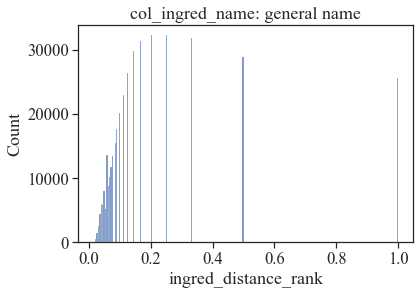

In [41]:
# producs_ingreds_spec_df.drop_duplicates(col_ingred_name)
g = sns.histplot(data=producs_ingreds_spec_df, x="ingred_distance_rank")

g.set(title='col_ingred_name: {}'.format(col_ingred_name))

In [42]:
ingreds_FPro_df = producs_ingreds_spec_df.groupby([col_ingred_name]).agg(
    count_products = ('original_ID', lambda x: len(set(x))),
    ingred_FPro = ('ingred_FPro', np.mean),
    avg_FPro_products = ('f_FPro', np.mean),
    
    avg_distance_root = ('distance_root', np.mean),
    ingred_normalization_term = ('ingred_normalization_term', np.mean),
    semantic_tree_name= ('semantic tree name', lambda x: set(x).pop()),
    semantic_tree_node= ('semantic tree node', lambda x: set(x).pop())
)

ingreds_FPro_df = ingreds_FPro_df.reset_index().sort_values('ingred_FPro', ascending=False)

if False:
    path_output = 'output/ingreds_approx_FPro_ingred_col_{}.xlsx'.format(col_ingred_name)
    ingreds_FPro_df.to_excel(path_output)

In [43]:
# ingreds_FPro_df[ingreds_FPro_df['count_products'] >= count_products_min]

[Text(0.5, 1.0, 'count_products_min: 10')]

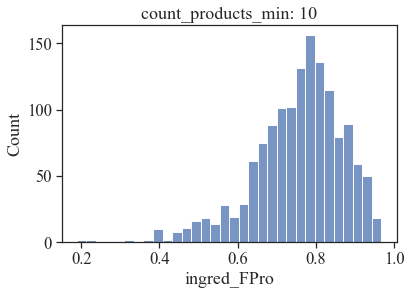

In [44]:
count_products_min = 10
g = sns.histplot(data=ingreds_FPro_df[ingreds_FPro_df['count_products'] >= count_products_min], x="ingred_FPro")

g.set(title='count_products_min: {}'.format(count_products_min))

In [45]:
# ingreds_FPro_df[ingreds_FPro_df['semantic_tree_name'] == 'oil']
ingreds_FPro_df[ingreds_FPro_df['count_products'] >= count_products_min].sort_values('count_products', ascending=False).head(20)

,general name,count_products,ingred_FPro,avg_FPro_products,avg_distance_root,ingred_normalization_term,semantic_tree_name,semantic_tree_node
5776,salt,18449,0.771194,0.804961,7.311507,3355.881355,salt,salt
6990,water,11305,0.765557,0.778267,2.944980,5589.143755,water,water
6346,sugar,10141,0.872800,0.852496,5.105709,3436.425659,None,None
4353,natural flavor,9455,0.792878,0.824151,11.198942,1073.813252,None,None
1835,contains 2% or less of,6751,0.809529,0.831587,6.543179,1245.010180,None,None
6998,wheat flour,6495,0.893683,0.882486,2.866821,3520.962751,flour,wheat flour
4106,milk,6259,0.713981,0.792449,5.501198,2588.856022,milk,milk
3669,lecithin,5805,0.846735,0.863951,11.931266,594.426799,None,None
1684,citric acid,4822,0.779160,0.820808,11.944629,574.444583,citric acid,citric acid
2567,folic acid,4736,0.887202,0.882309,9.596073,564.753885,None,None


1426


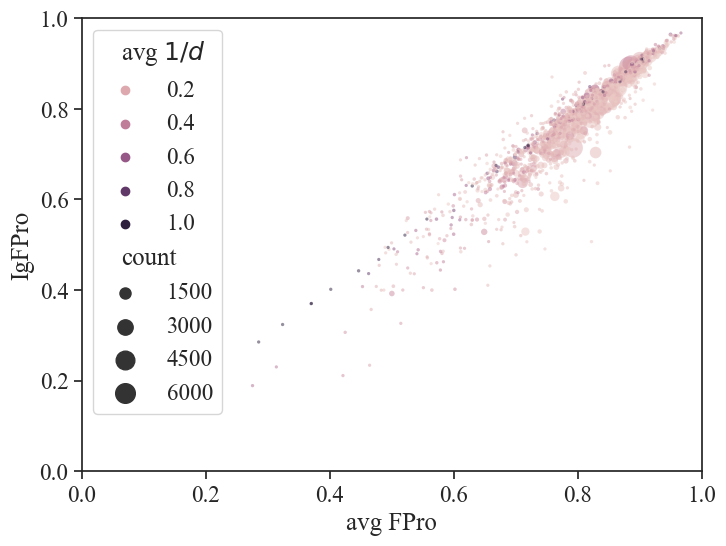

In [46]:
count_products_min = 10

ingreds_FPro_df['avg_distance_root rank'] =  1 / ingreds_FPro_df['avg_distance_root']
ingreds_FPro_df['count_products log'] =  ingreds_FPro_df['count_products'].apply(np.log)

data_plot_df = ingreds_FPro_df[ingreds_FPro_df['count_products'] >= count_products_min].sort_values(by='count_products', ascending=False)

fig, axs = plt.subplots(1, figsize=(8, 6), dpi=100)

print(len(data_plot_df))

g = sns.scatterplot(
    data=data_plot_df[data_plot_df['count_products'] < 9000], 
    x="avg_FPro_products", y="ingred_FPro",
#     size="count_used", sizes=(20, 200),
#     size=0,
    hue='avg_distance_root rank', alpha=0.5, linewidth=0, 
    size='count_products', sizes=(5, 200), size_norm=(1, 5000)
)


# plt.legend(title='avg $1/d$', loc='lower right', 
# #            labels=['Hell Yeh', 'Nah Bruh'])
#           )

# leg = g.axes.flat[0].get_legend()
leg = g.axes.get_legend()
leg.set_title('')
for i, t in enumerate(leg.texts):
# for t, l in zip(leg.texts, new_labels):
    if i == 0:
        t.set_text('avg $1/d$')
    if i == 6:
        t.set_text('count')
    pass

g.set(ylim=(0, 1), xlim=(0, 1))
g.set(xlabel='avg FPro', ylabel='IgFPro')

if False:
    g.set(title='count_products_min: {} | col_ingred_name: {}'.format(count_products_min, col_ingred_name))

In [47]:
data_plot_df.head()

,general name,count_products,ingred_FPro,avg_FPro_products,avg_distance_root,ingred_normalization_term,semantic_tree_name,semantic_tree_node,avg_distance_root rank,count_products log
5776,salt,18449,0.771194,0.804961,7.311507,3355.881355,salt,salt,0.136771,9.822765
6990,water,11305,0.765557,0.778267,2.944980,5589.143755,water,water,0.339561,9.333000
6346,sugar,10141,0.872800,0.852496,5.105709,3436.425659,None,None,0.195859,9.224342
4353,natural flavor,9455,0.792878,0.824151,11.198942,1073.813252,None,None,0.089294,9.154299
1835,contains 2% or less of,6751,0.809529,0.831587,6.543179,1245.010180,None,None,0.152831,8.817446


In [48]:
print('Ingreds with >= 1500 products: {} from {}'.format(
    sum(data_plot_df['count_products'] > 1500),
    len(data_plot_df)
))

data_plot_df[data_plot_df['count_products'] > 1500][['general name', 'count_products', 'ingred_FPro', 'avg_FPro_products', 'avg_distance_root']].reset_index(drop=True)

Ingreds with >= 1500 products: 56 from 1426


,general name,count_products,ingred_FPro,avg_FPro_products,avg_distance_root
0,salt,18449,0.771194,0.804961,7.311507
1,water,11305,0.765557,0.778267,2.944980
2,sugar,10141,0.872800,0.852496,5.105709
3,natural flavor,9455,0.792878,0.824151,11.198942
4,contains 2% or less of,6751,0.809529,0.831587,6.543179
5,wheat flour,6495,0.893683,0.882486,2.866821
6,milk,6259,0.713981,0.792449,5.501198
7,lecithin,5805,0.846735,0.863951,11.931266
8,citric acid,4822,0.779160,0.820808,11.944629
9,folic acid,4736,0.887202,0.882309,9.596073


[Text(0.5, 1.0, 'Number of Products Containing an Ingredient')]

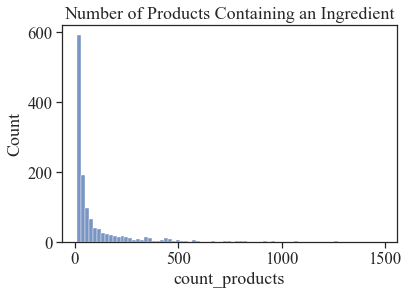

In [49]:
g = sns.histplot(data=data_plot_df[data_plot_df['count_products'] <= 1500], x="count_products")

g.set(title='Number of Products Containing an Ingredient'.format(len(data_plot_df)))

In [50]:
# ingreds_FPro_ranked[ingreds_FPro_ranked['general name'].str.contains('oil', case=False)]
# ingreds_FPro_ranked[ingreds_FPro_ranked['general name'] == 'avocado oil']['ingred_FPro'].values[0]
# ingreds_FPro_ranked[ingreds_FPro_ranked['general name'] == 'avocado oil']['rank'].values[0]

count_products_min: 10 | col_ingred_name: general name | num ingreds: 1426


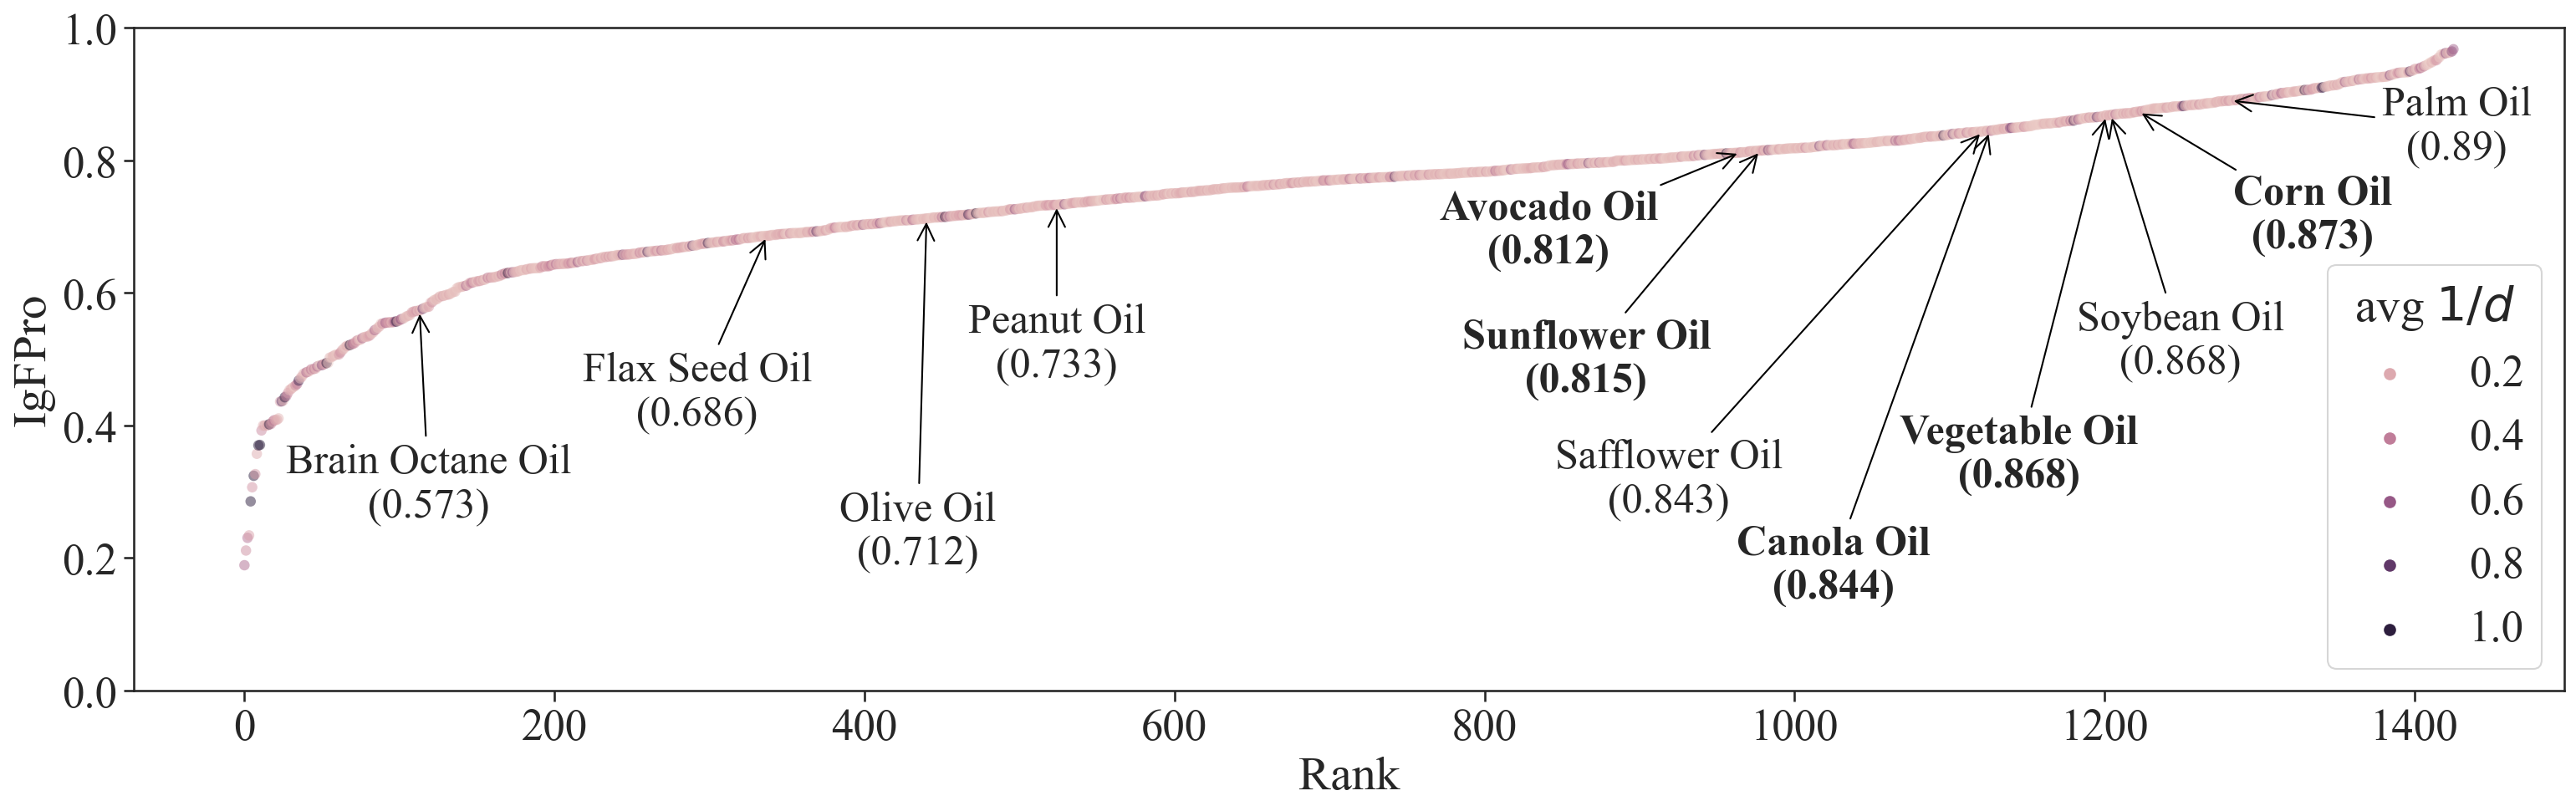

In [51]:
def annotate(g, data_df, ingred, xytext, fontsize, dround=3, write_IgFPro=False, bold=False):   
    x_val = data_df[data_df['general name'] == ingred]['rank'].values[0]
    y_val = data_df[data_df['general name'] == ingred]['ingred_FPro'].values[0]
    
    font_weight = None
    if write_IgFPro:
#         ingred = ingred + '\n({:.03f})'.format(y_val)
        ingred = ingred + '\n({})'.format(round(y_val, dround))
        
        if bold:
            font_weight = 'bold'
    
    g.annotate(
        text=ingred.title(), weight=font_weight,
        xy=(x_val, y_val),
        xycoords='data',
        fontsize=fontsize,
        xytext=xytext, 
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', color='black'),  # Use color black
        horizontalalignment='center',  # Center horizontally
        verticalalignment='center'  # Center vertically
    )
    pass


def plot_IGFPro(font_scale, figsize, dpi, annot_fontsize,verbose):
    count_products_min = 10

    ingreds_FPro_ranked = (
        ingreds_FPro_df[ingreds_FPro_df['count_products'] >= count_products_min]
        .sort_values('ingred_FPro', ascending=True)
        .reset_index(drop=True)
        .reset_index(drop=False)
        .rename(columns={'index': 'rank'})
    )

    ingreds_FPro_ranked['avg_distance_root log'] = ingreds_FPro_ranked['avg_distance_root'].apply(np.log)
    ingreds_FPro_ranked['avg_distance_root rank'] =  1 / ingreds_FPro_ranked['avg_distance_root']
    ingreds_FPro_ranked['count_products log'] = ingreds_FPro_ranked['count_products'].apply(np.log)

    sns.set(style="ticks", font="Times New Roman", font_scale=font_scale)

    # (15, 6)
    fig, axs = plt.subplots(1, figsize=figsize, dpi=dpi)

    g = sns.scatterplot(
        data=ingreds_FPro_ranked, 
        x="rank", y="ingred_FPro",
    #     size="count_used", sizes=(20, 200),
    #     size=0,
        hue='avg_distance_root rank', alpha=0.5, linewidth=0, 
    )

    g.set(ylim=(0, 1.0))

    annotate(g, ingreds_FPro_ranked, ingred='brain octane oil', xytext=(5, -100),fontsize=annot_fontsize,write_IgFPro=True)
    annotate(g, ingreds_FPro_ranked, ingred='flax seed oil', xytext=(-40, -90),fontsize=annot_fontsize,write_IgFPro=True)
    annotate(g, ingreds_FPro_ranked, ingred='olive oil', xytext=(-5, -180),fontsize=annot_fontsize,write_IgFPro=True)
    annotate(g, ingreds_FPro_ranked, ingred='peanut oil', xytext=(0, -80),fontsize=annot_fontsize,write_IgFPro=True)
    annotate(g, ingreds_FPro_ranked, ingred='avocado oil', xytext=(-110, -45),write_IgFPro=True,fontsize=annot_fontsize,bold=True)
    annotate(g, ingreds_FPro_ranked, ingred='sunflower oil', xytext=(-100, -120),write_IgFPro=True,fontsize=annot_fontsize,bold=True)
    annotate(g, ingreds_FPro_ranked, ingred='canola oil', xytext=(-90, -250),write_IgFPro=True,fontsize=annot_fontsize,bold=True)
    annotate(g, ingreds_FPro_ranked, ingred='vegetable oil', xytext=(-50, -195),write_IgFPro=True,fontsize=annot_fontsize,bold=True)
    annotate(g, ingreds_FPro_ranked, ingred='soybean oil', xytext=(40, -130),write_IgFPro=True,fontsize=annot_fontsize,dround=3)
    annotate(g, ingreds_FPro_ranked, ingred='safflower oil', xytext=(-180, -200),write_IgFPro=True,fontsize=annot_fontsize)
    annotate(g, ingreds_FPro_ranked, ingred='corn oil', xytext=(100, -60),write_IgFPro=True,fontsize=annot_fontsize,bold=True,dround=3)
    annotate(g, ingreds_FPro_ranked, ingred='palm oil', xytext=(130, -15),fontsize=annot_fontsize,write_IgFPro=True)
    # annotate(g, ingreds_FPro_ranked, ingred='palm kernel oil', xytext=(-10, -40),fontsize=annot_fontsize)

    plt.legend(title='avg $1/d$')#, loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])
    g.set(xlabel='Rank', ylabel='IgFPro')

    t_text = 'count_products_min: {} | col_ingred_name: {} | num ingreds: {}'.format(
            count_products_min, col_ingred_name, len(ingreds_FPro_ranked))
    
    if verbose:
        g.set(title=t_text)
    else:
        print(t_text)
    
    return ingreds_FPro_ranked

ingreds_FPro_ranked = plot_IGFPro(font_scale=2.3, figsize=(25, 7), dpi=150,annot_fontsize=24,verbose=False)
plt.savefig('output/fig6_A.pdf', bbox_inches='tight')

In [52]:
fig = px.scatter(ingreds_FPro_ranked, x="rank", y="ingred_FPro", color='avg_distance_root rank',
                hover_data=[col_ingred_name, 'count_products', 'avg_distance_root', 'avg_FPro_products'])
# fig.show()
# pio.show(fig)
pio.write_html(fig, file='output/IgFPro_index_1.html', auto_open=True)

In [53]:
# avg_FPro_products
print(stats.spearmanr(ingreds_FPro_ranked['avg_distance_root'], ingreds_FPro_ranked['ingred_FPro']))

ingreds_FPro_ranked['avg_distance_root log'] = ingreds_FPro_ranked['avg_distance_root'].apply(np.log)

fig = px.scatter(ingreds_FPro_ranked, x="avg_distance_root", y="ingred_FPro", color='avg_FPro_products',
                hover_data=[col_ingred_name, 'count_products', 'avg_FPro_products'])
pio.write_html(fig, file='output/IgFPro_index_2.html', auto_open=True)

SpearmanrResult(correlation=0.188845344618627, pvalue=6.489207777340776e-13)


In [54]:
if False:
    ingreds_FPro_ranked.to_excel('output/ingreds_FPro_ranked_042822.xlsx')

### Export GitHub

In [55]:
(
    ingreds_FPro_ranked.drop(columns=['rank', 'count_products log', 'avg_distance_root log', 'avg_distance_root rank'])
    .to_csv(path_github_data + '/GroceryDB_IgFPro.csv')
)

# Analyse Cereal Ingredients

In [59]:
print(["{:.8f}".format(float(n)) for n in np.logspace(-2, 0, 50, base=2)])

# gdb_df

['0.25000000', '0.25717393', '0.26455373', '0.27214529', '0.27995470', '0.28798821', '0.29625224', '0.30475341', '0.31349854', '0.32249461', '0.33174883', '0.34126860', '0.35106155', '0.36113552', '0.37149857', '0.38215900', '0.39312533', '0.40440635', '0.41601109', '0.42794883', '0.44022913', '0.45286183', '0.46585703', '0.47922514', '0.49297686', '0.50712319', '0.52167547', '0.53664533', '0.55204476', '0.56788609', '0.58418199', '0.60094552', '0.61819010', '0.63592952', '0.65417798', '0.67295010', '0.69226089', '0.71212583', '0.73256080', '0.75358217', '0.77520676', '0.79745189', '0.82033536', '0.84387548', '0.86809111', '0.89300162', '0.91862695', '0.94498763', '0.97210474', '1.00000000']


In [60]:
categorizing_strategy = ['custom-bins', 'all-in-one', 'novaclass', 'store-compare-cereal'][3]

if categorizing_strategy == 'custom-bins':
    strategy_categories = [(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.01)] 
    gdb_strat_df = gdb_df
    
elif categorizing_strategy == 'all-in-one':
    strategy_categories = [(0, 1.01)]
    gdb_strat_df = gdb_df
    
elif categorizing_strategy == 'store-compare-cereal':
    strategy_categories = ['Walmart', 'WholeFoods', 'Target']
    gdb_strat_df = gdb_all_df[gdb_all_df['harmonized single category'] == 'cereal'].reset_index(drop=True)
    
elif categorizing_strategy == 'novaclass':
    strategy_categories = [0, 1, 2 ,3]
    gdb_strat_df = gdb_df

    pass
    
print(categorizing_strategy, '-->', strategy_categories)
print(len(gdb_strat_df))

store-compare-cereal --> ['Walmart', 'WholeFoods', 'Target']
1168


## Individual Ingred Analysis

In [61]:
gdb_strat_df.columns

Index(['_id', 'original_ID', 'name', 'store', 'brand', 'url',
       'harmonized single category', 'isConverted', 'has10P', 'f_FPro',
       'f_min_FPro', 'f_FPro_class', 'ingredient_tree', 'bad_tree'],
      dtype='object')

In [62]:
producs_ingreds_strat_df = pd.merge(
    gdb_strat_df[['original_ID', 'name', 'url',
       'harmonized single category', 'isConverted', 'f_FPro', 'f_min_FPro',
       'f_FPro_class']],
    producs_ingreds_df,
    on='original_ID'
)

len(producs_ingreds_strat_df)

producs_ingreds_strat_df = producs_ingreds_strat_df[producs_ingreds_strat_df['bad_tree'] == False].reset_index(drop=True)

print('After removed bad tree:', len(producs_ingreds_strat_df))

After removed bad tree: 17839


In [63]:
producs_ingreds_strat_df['harmonized single category'].value_counts()

cereal    17839
Name: harmonized single category, dtype: int64

In [64]:
producs_ingreds_strat_df.columns

Index(['original_ID', 'name', 'url', 'harmonized single category',
       'isConverted', 'f_FPro', 'f_min_FPro', 'f_FPro_class', 'store',
       'bad_tree', 'original text', 'distance_root', 'order', 'order coded',
       'general name', 'cleaned name', 'descriptors', 'num descriptors',
       'type', 'additive id', 'semantic tree node', 'semantic tree name',
       'depth', 'width', 'branch', 'depth_branch'],
      dtype='object')

In [65]:
print('number of products in each store:\n', gdb_strat_df['store'].value_counts())
gdb_strat_df['store'].value_counts().mean()

number of products in each store:
 WholeFoods    415
Walmart       402
Target        351
Name: store, dtype: int64


389.3333333333333

In [66]:
len(producs_ingreds_strat_df)

17839

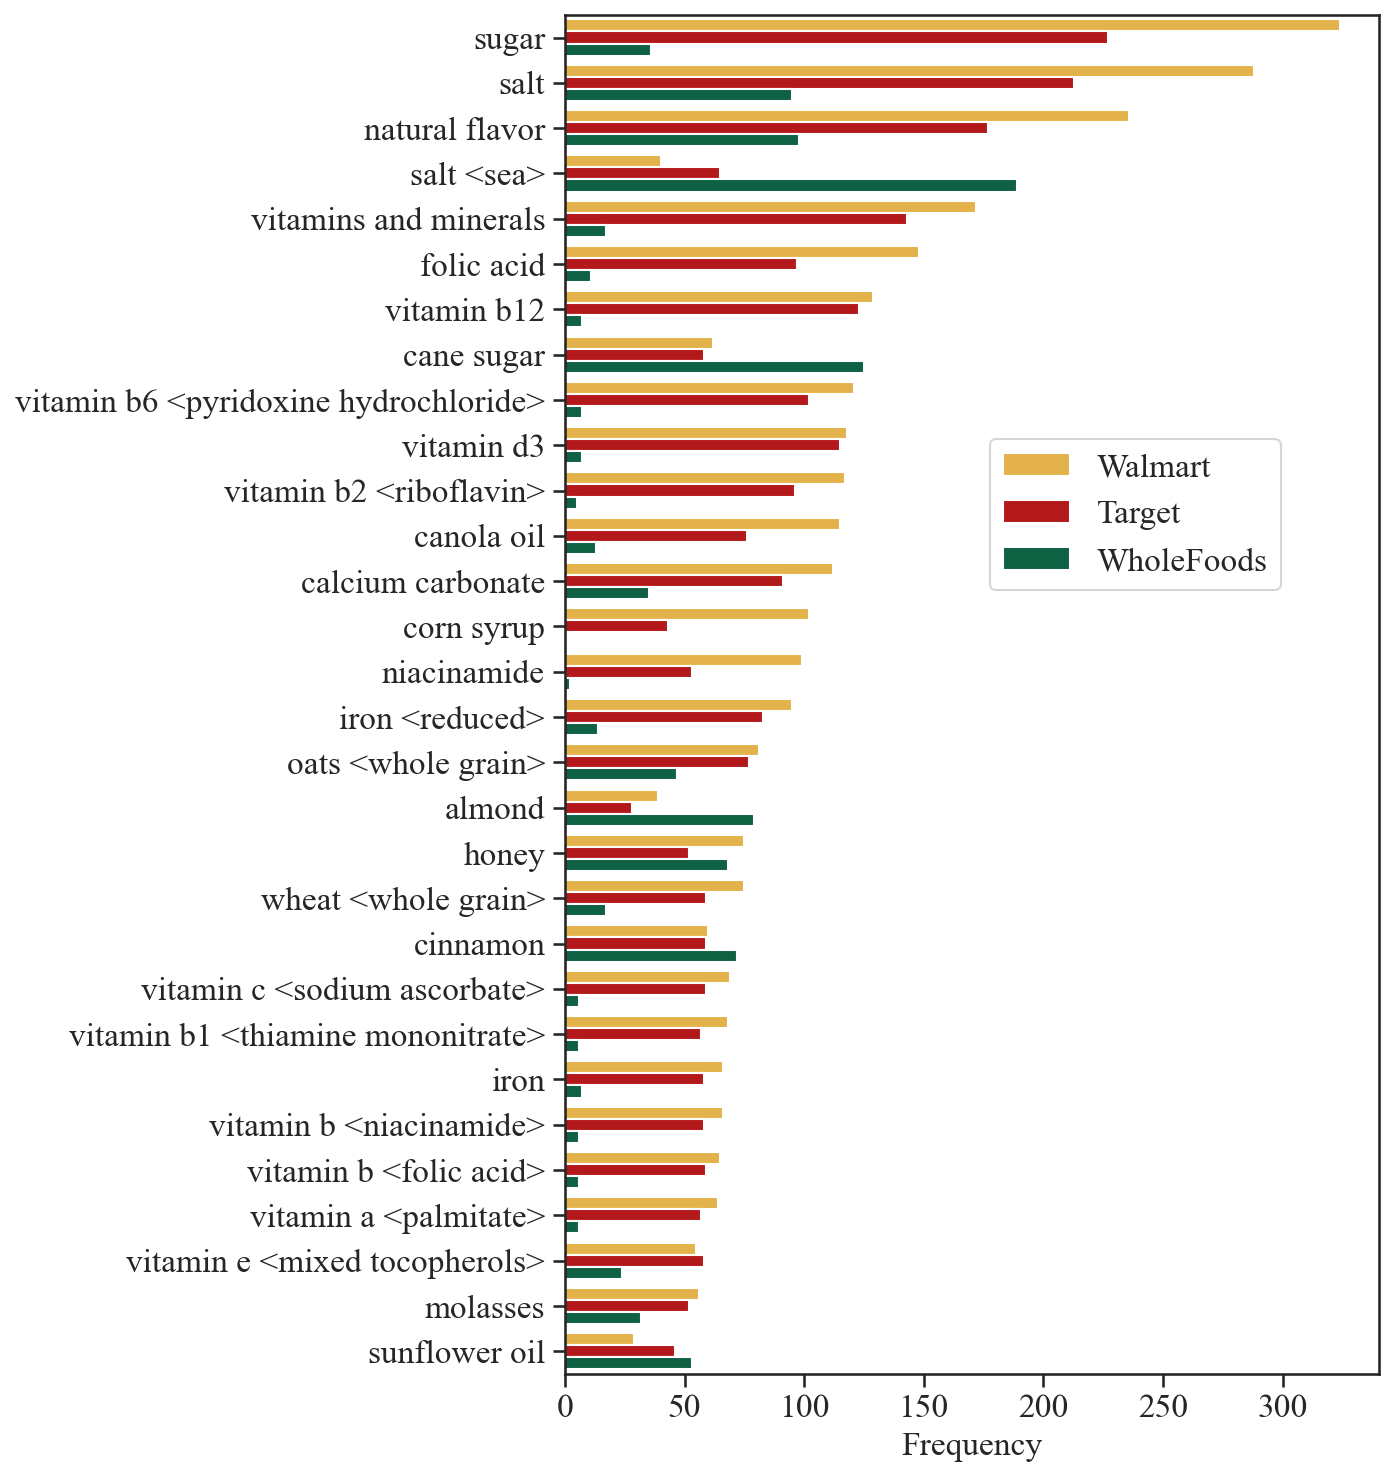

In [67]:
font_size = 16
SMALL_SIZE = font_size
MEDIUM_SIZE = font_size
BIGGER_SIZE = font_size

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
# {'additives': 'D:/SoftwareProject/GroceryDBDev/ingredient_tree/FDA_substances_added_to_food.csv'}
if True:
    col_ingred_name = ['cleaned name no desc', 'cleaned name'][1]
    type_ingred = [['ingredient'], ['additive'], ['ingredient', 'additive']][2]

    top_freq = [20, 30, 50][1]

    ingreds_most_imp = producs_ingreds_strat_df[producs_ingreds_strat_df['type'].isin(type_ingred)]
    '''FIX BAD INGRED NAME CREATED BY PETER'''
#     ingreds_most_imp = ingreds_most_imp.replace('a b vitamin', 'vitamin a b')
    ingreds_most_imp = (ingreds_most_imp
        .replace('a b vitamin <folic acid>', 'vitamin b <folic acid>')
        .replace('a b vitamin <niacinamide>', 'vitamin b <niacinamide>')
        .replace('a b vitamin <calcium pantothenate>', 'vitamin b <calcium pantothenate>')
    )
    
    if type_ingred == 'ingredient':
        ingreds_most_imp = (
            ingreds_most_imp[~ingreds_most_imp['cleaned name'].str.contains('sugar')]
            .reset_index(drop=True)
        )

    ingreds_most_imp = (
    #     producs_ingreds_strat_df[~producs_ingreds_strat_df['type'].isin(['marker', 'amount'])]
        ingreds_most_imp[ingreds_most_imp['type'].isin(type_ingred)]
        .groupby(['store', col_ingred_name])
        .agg(
            count_ingred = ('original_ID', np.size)
        )
        .sort_values(['count_ingred'], ascending=False)
        .reset_index()
    )

    order_of_ingreds_in_plot = (
        ingreds_most_imp.groupby('cleaned name')
        .agg({'count_ingred': np.sum})
        .sort_values(by='count_ingred', ascending=False)
        .reset_index()
    )

    top_ingreds = order_of_ingreds_in_plot.head(top_freq)[col_ingred_name]

''''''
# 16
# plt.figure(figsize=(9, 12), dpi=150)
plt.figure(figsize=(7, 12), dpi=150)

ingreds_most_filt_imp = ingreds_most_imp[ingreds_most_imp[col_ingred_name].isin(top_ingreds)]


ax = sns.barplot(
    y=col_ingred_name, 
    x="count_ingred",
    hue="store", 
    palette=grocery_base.colors_stores,
    hue_order = grocery_base.colors_stores.keys(),
#     col="time",
    data=ingreds_most_filt_imp
)

ax.legend(
#         fontsize=8,
        bbox_to_anchor=(0.9, 0.7)
    )

ax.set(
    xlabel='Frequency', 
    ylabel=''
)
''''''

plt.savefig('output/fig4_B.pdf', bbox_inches='tight')

if False:
    ax.set(title='Ingred-Type: {} Num-Products: {}\nType:{} | Top-ingred:{}\n'.format(
        type_ingred, len(gdb_strat_df), type_ingred, top_freq))

# Challenges


- Annotate SNS Scatter plot https://towardsdatascience.com/finally-learn-to-annotate-place-text-in-any-part-of-the-plot-d9bcc93c153f
- Move Legend https://stackoverflow.com/questions/27019079/move-seaborn-plot-legend-to-a-different-position
- BEST http://degradome.uniovi.es/cgi-bin/nVenn/nvenn.cgi
- http://www.interactivenn.net/index.html
- https://www.python-graph-gallery.com/172-custom-venn-diagram
- http://www.interactivenn.net/
- not that good but does 4 sets https://github.com/ksahlin/pyinfor/blob/master/venn.py
- https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-35